In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

import os
for dirname, _, filenames in os.walk('./data_watermelon/digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data_watermelon/digit-recognizer\sample_submission.csv
./data_watermelon/digit-recognizer\test.csv
./data_watermelon/digit-recognizer\train.csv


In [3]:
base_train = pd.read_csv('./data_watermelon/digit-recognizer/train.csv')
base_test = pd.read_csv('./data_watermelon/digit-recognizer/test.csv')
print(base_train.shape, base_test.shape)

(42000, 785) (28000, 784)


In [4]:
base_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Total Amount of Unique Labels in the Database

In [5]:
# Lista ordenada dos Rótulos da classe
sorted(base_train["label"].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Separating the Pixels of the Images from the Labels

In [6]:
x = base_train.drop("label", axis = 1)
y = base_train["label"]

In [7]:
print(x.shape, y.shape)

(42000, 784) (42000,)


# Separating Training Database and Test Database

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [9]:
print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(33600, 784) (8400, 784)
(33600,) (8400,)


# Reshape 

In [10]:
x_train = np.array(x_train).astype("float32")
x_test = np.array(x_test).astype("float32")

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [11]:
x_train.shape

(33600, 28, 28, 1)

In [12]:
x_train[1].dtype

dtype('float32')

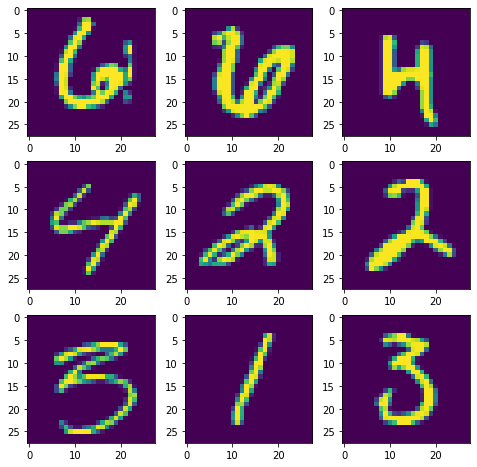

In [13]:
fig = plt.figure(figsize = (8, 8))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

# Normalize 

In [14]:
x_train = x_train / 255
x_test = x_test / 255

In [15]:
x_train.shape[1:]

(28, 28, 1)

# Structure of the Convolutional Neural Network with Tensorflow and Keras

In [16]:
classifier = Sequential()

classifier.add(Conv2D(64, (5, 5), activation = "relu", padding="same", input_shape = (28, 28, 1)))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D((2, 2)))

classifier.add(Conv2D(64, (5, 5), activation = "relu", padding="same"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation = "relu", padding="same"))
classifier.add(BatchNormalization())
classifier.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
classifier.add(Dropout(0.2))

classifier.add(Conv2D(64, (3, 3), activation = "relu", padding="same"))
classifier.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

classifier.add(Conv2D(64, (3, 3), activation = "relu", padding="same"))
classifier.add(Dropout(0.2))

classifier.add(Flatten())

classifier.add(Dense(units = 256, activation = "relu"))
classifier.add(BatchNormalization())
classifier.add(Dropout(0.3))

classifier.add(Dense(units = 10, activation = "softmax"))

In [17]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        1664      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        102464    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0

# Convolutional Neural Network Architecture

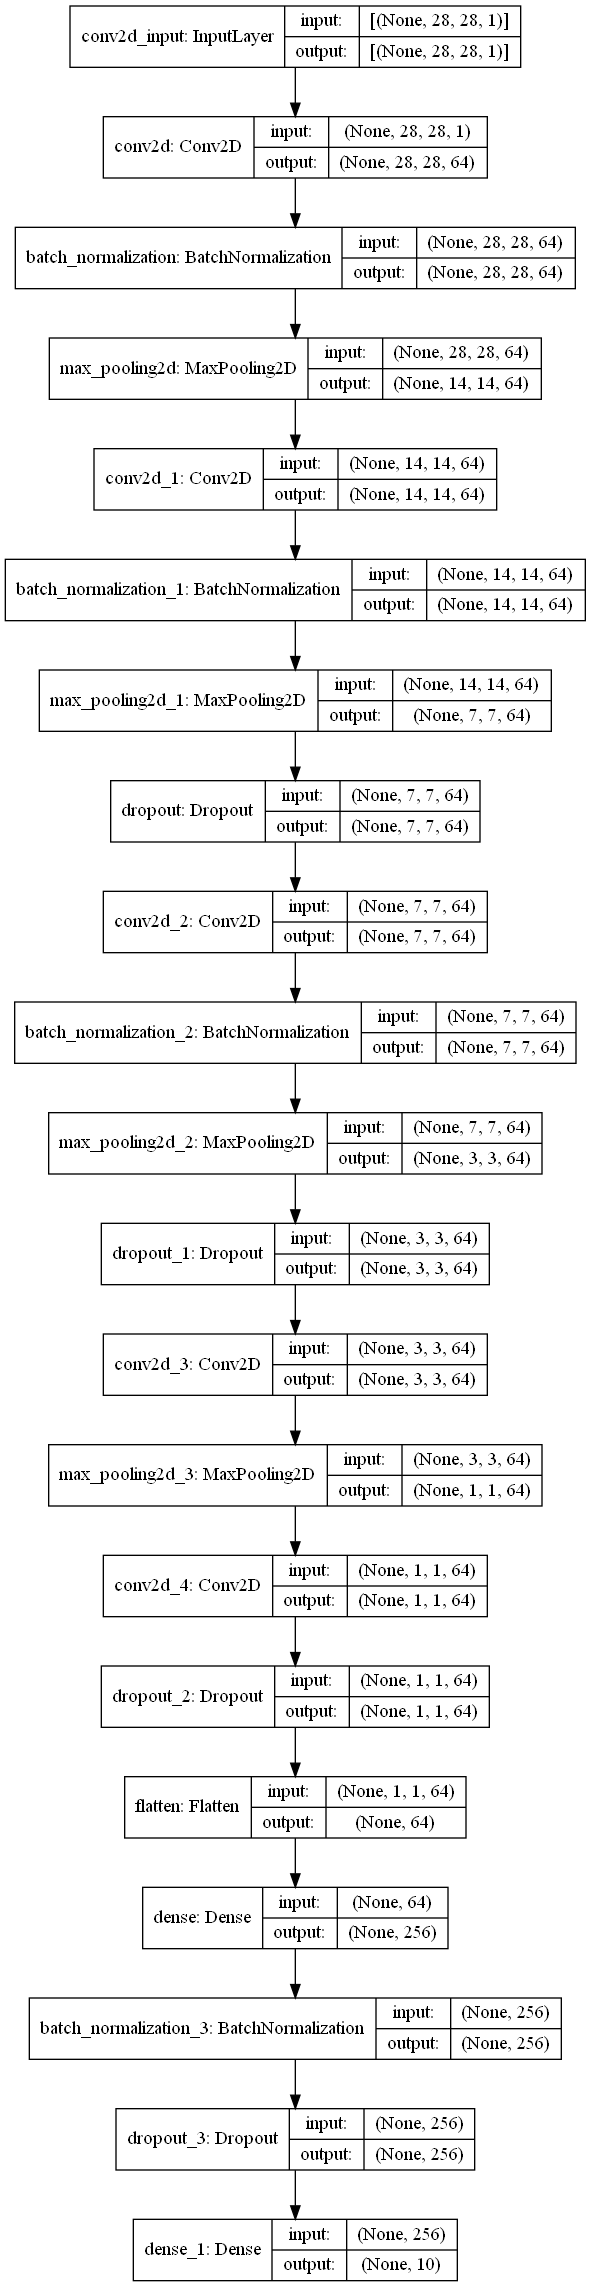

In [19]:
from keras.utils.vis_utils import plot_model
plot_model(classifier, to_file='./img/classifier.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("./img/classifier.png")

# Compiling the Model

In [20]:
classifier.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

# Training the Model

In [23]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Image Data Generator

In [24]:
data_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=False,
        vertical_flip=False)

data_generator.fit(x_train)

In [25]:
history = classifier.fit(data_generator.flow(x_train,y_train, batch_size=128),
                              epochs = 100, validation_data = (x_test,y_test),
                              verbose = 2, steps_per_epoch=x_train.shape[0] // 128,
                              callbacks=[learning_rate_reduction])

Epoch 1/100
262/262 - 63s - loss: 0.7927 - accuracy: 0.7358 - val_loss: 2.0117 - val_accuracy: 0.1067
Epoch 2/100
262/262 - 52s - loss: 0.1829 - accuracy: 0.9462 - val_loss: 0.1990 - val_accuracy: 0.9443
Epoch 3/100
262/262 - 48s - loss: 0.1343 - accuracy: 0.9612 - val_loss: 0.0745 - val_accuracy: 0.9814
Epoch 4/100
262/262 - 52s - loss: 0.1078 - accuracy: 0.9692 - val_loss: 0.0453 - val_accuracy: 0.9868
Epoch 5/100
262/262 - 51s - loss: 0.0877 - accuracy: 0.9752 - val_loss: 0.0478 - val_accuracy: 0.9877
Epoch 6/100
262/262 - 50s - loss: 0.0849 - accuracy: 0.9751 - val_loss: 0.0386 - val_accuracy: 0.9885
Epoch 7/100
262/262 - 52s - loss: 0.0757 - accuracy: 0.9782 - val_loss: 0.0531 - val_accuracy: 0.9858
Epoch 8/100
262/262 - 49s - loss: 0.0736 - accuracy: 0.9793 - val_loss: 0.0442 - val_accuracy: 0.9875
Epoch 9/100
262/262 - 54s - loss: 0.0660 - accuracy: 0.9806 - val_loss: 0.0408 - val_accuracy: 0.9877
Epoch 10/100
262/262 - 48s - loss: 0.0631 - accuracy: 0.9817 - val_loss: 0.0443 - 

In [26]:
 #history.history 

# Evaluation of the Trained Model

In [27]:

def graphic_evaluation(history,materics,graphic_title):
    plt.plot(history.history[materics])
    plt.plot(history.history['val_'+materics])
    plt.title(graphic_title, fontsize = 16)
    plt.legend(['train','test'])
    plt.xlabel('Epochs', fontsize = 15)
    plt.ylabel(materics, fontsize = 15)
    plt.show()

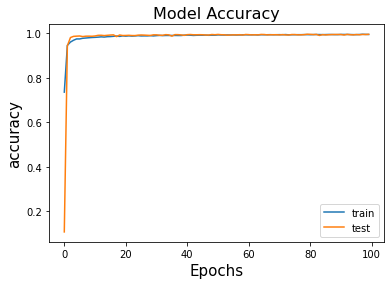

In [28]:
# ploting the accuracy
graphic_evaluation(history,'accuracy', 'Model Accuracy')

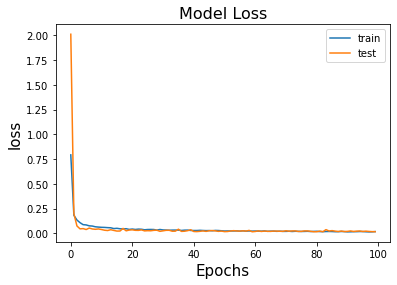

In [29]:
# ploting the model loss
graphic_evaluation(history, 'loss', 'Model Loss')

# Save submition

In [30]:
x_test_sub = base_test.copy()

In [31]:
x_test_sub = x_test_sub.values.reshape(-1,28,28,1)
x_test_sub = x_test_sub.astype('float32')/255.0

In [32]:
pred_x_test_sub = classifier.predict(x_test_sub)

In [33]:
pred_x_test_sub

array([[8.4839656e-11, 6.1478773e-11, 1.0000000e+00, ..., 5.6963598e-09,
        1.0925304e-09, 3.4468695e-12],
       [9.9999893e-01, 7.3119129e-11, 7.3507692e-08, ..., 1.8080674e-09,
        5.3137290e-09, 3.5641925e-08],
       [1.6856956e-07, 9.7320223e-09, 6.4804517e-09, ..., 2.0727798e-06,
        1.3769451e-06, 9.9993646e-01],
       ...,
       [1.8721324e-13, 7.7850154e-14, 8.0658104e-13, ..., 8.7361374e-13,
        6.8071278e-12, 1.7451933e-12],
       [6.2093051e-08, 3.3956093e-09, 1.4283096e-09, ..., 3.4231917e-07,
        6.3770408e-08, 9.9997842e-01],
       [6.0864803e-12, 2.1599599e-12, 1.0000000e+00, ..., 4.1520087e-10,
        1.3691062e-10, 1.7167761e-13]], dtype=float32)

In [34]:
my_submition = pd.DataFrame({'ImageId':base_test.index.values + 1, 'Label':np.argmax(pred_x_test_sub, axis=1)})

In [35]:
my_submition

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [36]:
my_submition.to_csv('./data_watermelon/digit-recognizer/digit_mnist.csv', index=False)

In [37]:
ls

 ������ D �еľ��� �¼Ӿ�
 �������к��� DA1A-1BFA

 d:\King\study\code\Margin-Learning\Watermelon ��Ŀ¼

2021/06/01  13:50    <DIR>          .
2021/06/01  13:50    <DIR>          ..
2021/05/29  16:01    <DIR>          .ipynb_checkpoints
2021/05/28  16:57    <DIR>          __pycache__
2021/04/16  23:08            93,548 0201_ml_cost_curve.ipynb
2021/05/21  15:51            36,970 0301_logit.ipynb
2021/05/17  16:54            60,921 0302_LDA_demo.ipynb
2021/06/01  09:46           290,700 0401_decision_tree.ipynb
2021/05/29  16:27            74,093 0501_BP.ipynb
2021/05/31  14:28            16,814 0502_RBF.ipynb
2021/06/01  10:43           189,604 0503_CNN_digit-recognizer-dataset-mnist.ipynb
2021/04/16  23:08            19,693 0601.ipynb
2021/04/16  23:08            19,839 0901_mixture_of_Gaussian.ipynb
2021/04/16  23:08            38,302 0902_GMM.ipynb
2021/04/16  23:08            16,425 1001_PCA.ipynb
2021/04/16  23:08             6,418 1002_PCA.ipynb
2021/04/16  23:08             4,965 1003